In [1]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
# Use read_tsv because some lines have commas in them which aren't escaped, and so fields are separated with tabs
rawPlaces <- read_tsv('places_filtered_columns.tsv', col_names = c("id", "name", "split", "type", "grid", "lat", "long"),
                   col_types = "iciccdd", trim_ws = TRUE, skip=1)

# add columns for lat and long rounded to 1 dp for fuzzy matching later
rawPlaces$lat0dp <- round(rawPlaces$lat, digits = 0)
rawPlaces$long0dp <- round(rawPlaces$long, digits = 0)

# add a clean version of the name - hyphens become spaces, and any suffix giving the type (e.g. BUA) is removed
rawPlaces$cleanName <- gsub('-', ' ', str_replace(rawPlaces$name, " [A-Z]+$", ""))


In [3]:
# start with just LOC and COM lines (these might contain duplicate placeids via splitind=1)
# Note these might have duplicates, but they're just splits of unique places, rather than different kinds of places
# with the same name and location
placesWithoutDuplicates <- rawPlaces %>% filter(type == "LOC" | type == "COM")

findRowsToAddForLineType <- function(lineType) {
    allLinesOfType <- rawPlaces %>% filter(type == lineType)
    
    joinByCleanName <- left_join(allLinesOfType, placesWithoutDuplicates, by = "cleanName")

    # if a name's completely new, store its id to add later
    idsForNewNames <- joinByCleanName %>% filter(is.na(id.y)) %>% select(id.x)

    # if it's not a new name, check it isn't in the same grid square as a place with that name, or matches
    # a place with the name based on rough long and lat
    needToCheckLocation <- allLinesOfType %>% filter(!id %in% idsForNewNames$id.x)
    
    matchOnNameAndGridSquare <- left_join(needToCheckLocation, placesWithoutDuplicates,
                                          by = c("cleanName" = "cleanName", "grid" = "grid"))
    matchOnNameAndRoughLongLat <- left_join(needToCheckLocation, placesWithoutDuplicates,
                                            by = c("cleanName" = "cleanName", "lat0dp" = "lat0dp", "long0dp" = "long0dp"))
    
    matchesOnNameAndGridSquare <- matchOnNameAndGridSquare %>% filter(!is.na(id.y)) %>% group_by (id.x) %>% tally()
    noMatchesOnNameAndGridSquare <- matchOnNameAndGridSquare %>% filter(is.na(id.y)) %>% group_by (id.x) %>% tally()
    matchesOnNameAndRoughLongLat <- matchOnNameAndRoughLongLat %>% filter(!is.na(id.y)) %>% group_by (id.x) %>% tally()
    noMatchesOnNameAndRoughLongLat <- matchOnNameAndRoughLongLat %>% filter(is.na(id.y)) %>% group_by (id.x) %>% tally()

    summary <- matchesOnNameAndGridSquare %>%
        full_join(noMatchesOnNameAndGridSquare, by="id.x", suffix=c(".matchOnGridSquare", ".noMatchOnGridSquare")) %>%
        full_join(matchesOnNameAndRoughLongLat, by="id.x") %>%
        full_join(noMatchesOnNameAndRoughLongLat, by="id.x", suffix=c(".matchOnRoughLongLat", ".noMatchOnRoughLongLat"))
    
    idsForOldNamesInNewPlaces <- summary %>%
                    filter(is.na(n.matchOnGridSquare) & !is.na(n.noMatchOnGridSquare) &
                           is.na(n.matchOnRoughLongLat) & !is.na(n.noMatchOnRoughLongLat)) %>%
                    select(id.x)
    
    idsToAdd <- c(idsForNewNames$id.x, idsForOldNamesInNewPlaces$id.x)
    
    toAdd <- allLinesOfType %>% filter(id %in% idsToAdd)
    
    toAdd
}

newParishes <- findRowsToAddForLineType('PAR')

placesWithoutDuplicates <- bind_rows(placesWithoutDuplicates, newParishes)

In [4]:
places <- placesWithoutDuplicates[!duplicated(placesWithoutDuplicates$id), ]

In [12]:
# joiningWords was populated by running this and then picking from the output by eye
#anyLowerCasePattern <- " ([a-z]+) "
#uniqueLowerCaseWords <- sort(unique(gsub("[- ]", "", na.omit(str_match(places$cleanName, anyLowerCasePattern)))))

joiningWords <- c('by the', 'de la', 'en le', 'in the', 'next the', 'on the',
                  'and', 'ac', 'at', 'atte', 'by', 'cum', 'de', 'gyda', 'in', 'juxta', 'le', 'nan', 'na', 'an', 'near',
                  'next','of', 'on', 'over', 'sub', 'super', 'under', 'upon', 'with')

results <- tibble(id = places$id, name = places$name)

for (x in joiningWords)
{
    colName <- gsub(' ', '_', x)
    
    includePattern <- paste(" ", x, " ", sep='')
    
    wordsToExclude <- str_subset(joiningWords[joiningWords != x], x)
    
    includesTheRightThing <- str_detect(places$cleanName, includePattern)
    
    if (length(wordsToExclude)) {
        excludePattern <- paste(' (', paste(wordsToExclude, collapse='|'), ') ', sep='')
        
        includesAWrongThing <- str_detect(places$cleanName, excludePattern)
        results <- add_column(results, !!(colName) := includesTheRightThing & !includesAWrongThing)
    } else {
        results <- add_column(results, !!(colName) := includesTheRightThing)
    }
}

# 'without' appears to not always have another word after it, so search for it separately
results$without <- str_detect(places$cleanName, "\\b[Ww]ithout\\b")

In [15]:
countByJoiningWord <- tibble(Word=character(), Count=numeric())
examplePlaceForJoiningWord <- tibble(Word=character(), Example=character())

allWords <- c(joiningWords, 'without')

for (x in allWords)
{
    colName <- gsub(' ', '_', x)
    
    countByJoiningWord <- countByJoiningWord %>% add_row(Word=x, Count=nrow(results %>% filter(!!as.name(colName))))
    
    placesForWord <- places %>%
        filter(pull(results, !!(colName)))
    
    examplePlaceForJoiningWord <- examplePlaceForJoiningWord %>% add_row(Word=x,
                                                                         Example=placesForWord[[1, "name"]])
}

(examplePlaceForJoiningWord)

Word,Example
by the,High Newton-by-the-Sea
de la,Ashby de la Launde
en le,Alsop en le Dale
in the,Barton in the Beans
next the,Holme next the Sea
on the,Amersham on the Hill
and,Basset (Wheal Basset and Grylls)
ac,Abergwaun ac Wdig
at,Court-at-Street
atte,Havering-atte-Bower


In [16]:
# transformation to TopoJSON
scaleLong <- 0.001546403012701271
scaleLat <- 0.0010939367048704803
translateLong <- -13.69131425699993
translateLat <- 49.90961334800009

coordToTopoJSON <- function(coord, scale, translate) {
    round((coord - translate) / scale, digits = 0)
}

coord2TopoJSON <- Vectorize(coordToTopoJSON, "coord")

results$topoJSONlat <- coord2TopoJSON(places$lat, scaleLat, translateLat)
results$topoJSONlong <- coord2TopoJSON(places$long, scaleLong, translateLong)

# this is a hard-coded list, but keeps things simple by reducing the data volume a lot
interestingResults <- results %>% filter(by_the | de_la | en_le | in_the | next_the | on_the |
                  and | ac | at | atte | by | cum | de | gyda | `in` | juxta | le | `nan` | `na` | `an` |
                  near | `next` | of | on | over | sub | super | under | upon | with | without)

(interestingResults)


id,name,by_the,de_la,en_le,in_the,next_the,on_the,and,ac,...,on,over,sub,super,under,upon,with,without,topoJSONlat,topoJSONlong
309,Abingdon-on-Thames,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,1609,8025
377,Achdh an Inbhir,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,7391,5417
399,Ach na Cloiche,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,6580,4983
410,Achadh na Sine,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,7009,5568
591,Adwick le Street,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,3350,8082
674,?ird nan Str<U+0097>ban,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,6935,4153
1032,Allhallows-on-Sea,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,1430,9275
1045,Allington (West Allington with East Allington),FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE,2782,8382
1080,Allt nan S<U+0097>gh,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,6766,5307
1167,Alsop en le Dale,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,...,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,2910,7715


In [17]:
# We want to collect all the columns that are true for a given row, so that we can use them to create the CSS class
# in the output.  However, this is painfully slow, and tranposing rows / columns is quick, so create a copy of just the
# data we need for this step into a new tibble, transpose it, then process each column (which is how we process each
# place in the transposed tibble).  Collect these results and add them as a new column to the original tibble.

flags <- interestingResults %>% select(-one_of(c('topoJSONlong', 'topoJSONlat', 'name')))
tflags <- as_tibble(cbind(nms = names(flags), t(flags)))

(tflags)

classes <- c()

allCols <- names(tflags)

dataCols <- allCols[!grepl("nms", allCols)]

for(x in dataCols) {
    print(x)
    print(tflags[[x]])
    classList <- tflags$nms[tflags[[x]] == 1]
    print(classList)
    classes <- c(classes, paste(classList, collapse=" "))
}

interestingResults$classes <- classes

(classes)

forOutput <- tibble(topoJSONlong = interestingResults$topoJSONlong,
                    topoJSONlat = interestingResults$topoJSONlat,
                    name = interestingResults$name,
                    classes = interestingResults$classes)

(forOutput)


nms,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V1721,V1722,V1723,V1724,V1725,V1726,V1727,V1728,V1729,V1730
id,309,377,399,410,591,674,1032,1045,1080,...,117183,117196,117206,117214,117215,117270,117273,117280,117334,117416
by_the,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
de_la,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
en_le,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
in_the,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
next_the,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
on_the,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
and,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
ac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
at,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] "V1"
 [1] "309" "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[13] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[25] "1"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[1] "on"
[1] "V2"
 [1] "377" "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[13] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "1"   "0"   "0"   "0"  
[25] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[1] "an"
[1] "V3"
 [1] "399" "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[13] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "1"   "0"   "0"   "0"   "0"  
[25] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[1] "na"
[1] "V4"
 [1] "410" "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[13] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "1"   "0"   "0"   "0"   "0"  
[25] "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[1] "na"
[1] "V5"
 [1] "591" "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"   "0"  
[13] "0"   "0"

[1] "on"          "an"          "na"          "na"          "le"         
   [6] "nan"         "on"          "with"        "nan"         "en_le"      
  [11] "on_the"      "le"          "le"          "by"          "de_la"      
  [16] "in"          "on"          "under"       "upon"        "in"         
  [21] "by"          "on"          "on"          "on"          "na"         
  [26] "of"          "of"          "of"          "of"          "of"         
  [31] "of"          "nan"         "an"          "nan"         "of"         
  [36] "le"          "of"          "in_the"      "in_the"      "on"         
  [41] "upon"        "in"          "and"         "of"          "of"         
  [46] "of"          "on"          "on"          "in"          "in"         
  [51] "of"          "upon"        "cum"         "na"          "of"         
  [56] "of"          "of"          "on"          "on"          "on"         
  [61] "of"          "in_the"      "on"          "of"          "of"         
  [66] "na"          "en_le"       "and without" "an"          "of"         
  [71] "of"          "of"          "of"          "of"          "of"         
  [76] "of"          "of"          "of"          "of"          "of"         
  [81] "of"          "of"          "of"          "of"          "le"         
  [86] "of"          "in"          "of"          "of"          "na"         
  [91] "next"        "in"          "and"         "of"          "on_the"     
  [96] "le"          "upon"        "of"          "on_the"      "an"         
 [101] "upon"        "de"          "na"          "le"          "of"         
 [106] "of"          "on_the"      "le"          "cum"         "upon"       
 [111] "of"          "of"          "na"          "of"          "of"         
 [116] "on"          "on_the"      "an"          "le"          "on"         
 [121] "of"          "of"          "of"          "and"         "and"        
 [126] "of"          "de"          "in_the"      "at"          "of"         
 [131] "na"          "of"          "on"          "on"          "of"         
 [136] "of"          "of"          "of"          "on"          "at"         
 [141] "in"          "of"          "an"          "nan"         "on_the"     
 [146] "an"          "of"          "in"          "in"          "of"         
 [151] "upon"        "of"          "with"        "of"          "of"         
 [156] "de"          "and"         "and"         "le"          "and"        
 [161] "on_the"      "an"          "on"          "na"          "with"       
 [166] "of"          "upon"        "and"         "and"         "on_the"     
 [171] "in"          "on"          "and"         "de_la"       "de"         
 [176] "in"          "and"         "on_the"      "on"          "on_the"     
 [181] "on_the"      "of"          "of"          "na"          "an"         
 [186] "and"         "by"          "on"          "of"          "on"         
 [191] "on"          "and"         "with"        "on"          "at"         
 [196] "of"          "and"         "on_the"      "and"         "cum"        
 [201] "on_the"      "and"         "of"          "of"          "of"         
 [206] "atte"        "on"          "of"          "on_the"      "in"         
 [211] "and"         "le"          "le"          "and"         "by_the"     
 [216] "and"         "of"          "of"          "of"          "of"         
 [221] "of"          "in_the"      "in_the"      "on"          "on_the"     
 [226] "on_the"      "le"          "le"          "le"          "on"         
 [231] "of"          "with"        "in_the"      "le"          "with"       
 [236] "in"          "of"          "of"          "of"          "of"         
 [241] "of"          "of"          "of"          "of"          "in_the"     
 [246] "of"          "by"          "upon"        "upon"        "an"         
 [251] "le"          "on"          "in"          "in"          "of"         
 [256] "of"          "of"          "of"          "of"          "of"         

topoJSONlong,topoJSONlat,name,classes
8025,1609,Abingdon-on-Thames,on
5417,7391,Achdh an Inbhir,an
4983,6580,Ach na Cloiche,na
5568,7009,Achadh na Sine,na
8082,3350,Adwick le Street,le
4153,6935,?ird nan Str<U+0097>ban,nan
9275,1430,Allhallows-on-Sea,on
8382,2782,Allington (West Allington with East Allington),with
5307,6766,Allt nan S<U+0097>gh,nan
7715,2910,Alsop en le Dale,en_le


In [18]:
write_tsv(forOutput, 'output.tsv', na = "NA")

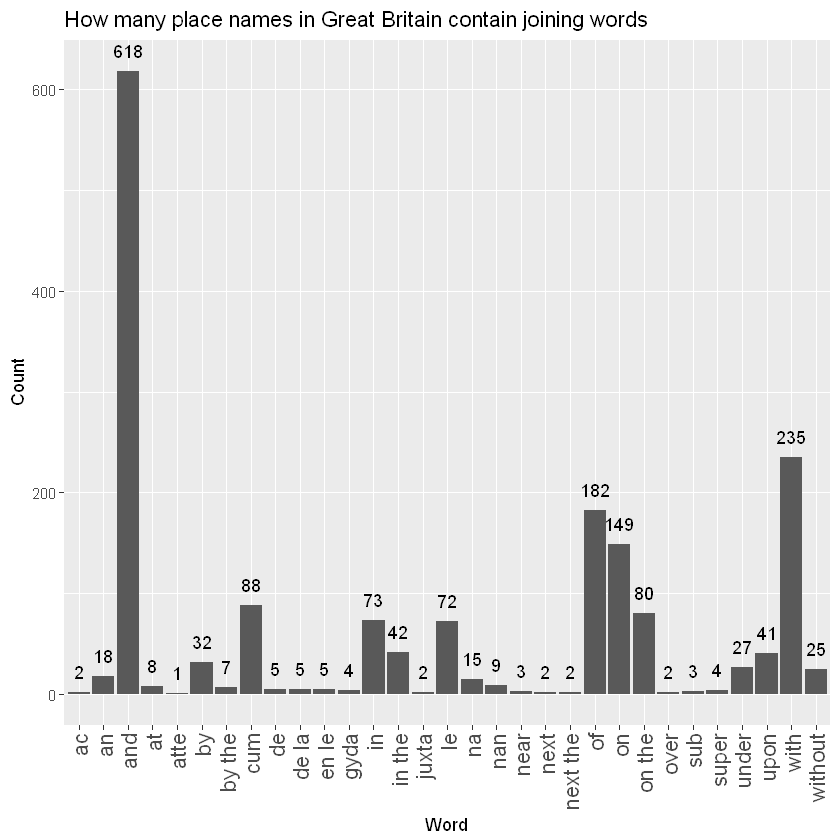

In [19]:
ggplot(data=countByJoiningWord, aes(x=Word, y=Count)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label=Count, vjust=-1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=13)) +
    ggtitle("How many place names in Great Britain contain joining words")

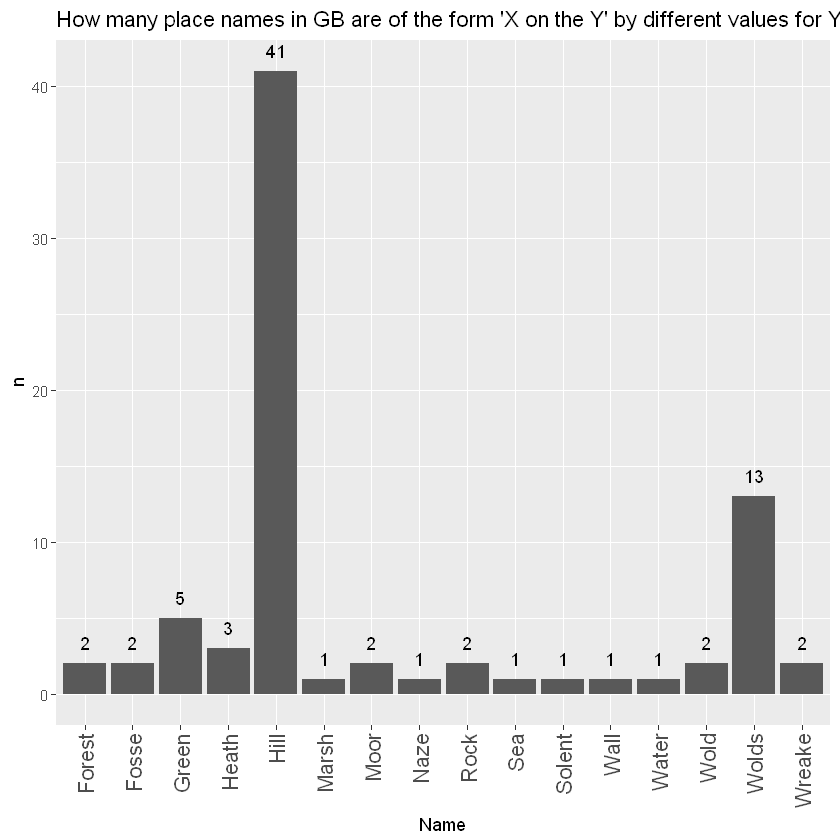

In [20]:
placesToBeOn <- tibble(Name = str_match(filter(places, results$on_the)$cleanName, " on the ([a-zA-Z]+)")[,2])
onPlacesCount <- placesToBeOn %>% count(Name)

barThreshold <- 100
onPlacesCount <- mutate(onPlacesCount,
       labelPosition = ifelse(n > barThreshold, 2, -1))

ggplot(data=onPlacesCount, aes(x=Name, y=n)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label=n, vjust=labelPosition)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=13)) +
    ggtitle("How many place names in GB are of the form 'X on the Y' by different values for Y")

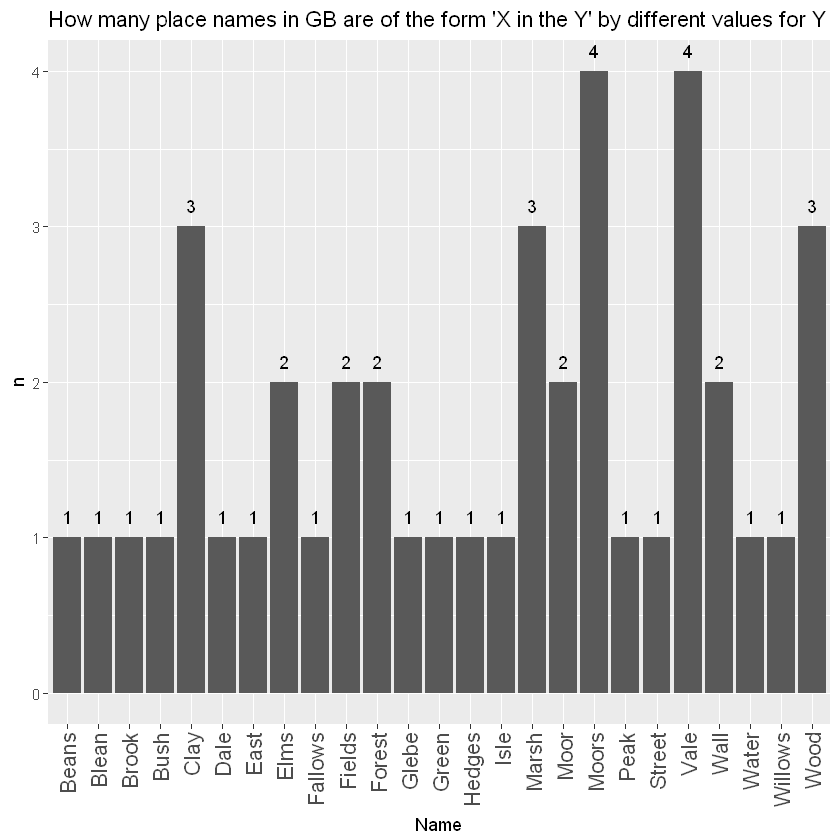

In [21]:
placesToBeIn <- tibble(Name = str_match(filter(places, results$in_the)$cleanName, " in the ([a-zA-Z]+)")[,2])
inPlacesCount <- placesToBeIn %>% count(Name)

ggplot(data=inPlacesCount, aes(x=Name, y=n)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label=n, vjust=-1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=13)) +
    ggtitle("How many place names in GB are of the form 'X in the Y' by different values for Y")

In [22]:
interestingResults %>% filter(interestingResults$`by_the`) %>% select(name)

name
High Newton-by-the-Sea
Low Newton-by-the-Sea
Marske-by-the-Sea
Newbiggin-by-the-Sea
Saltburn-by-the-Sea
Amble by the Sea
Newton-by-the-Sea
